In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Сгенерируем выборку
X = np.random.uniform(low=0, high=20, size=(500,1))

def target(x):
    return x + 3 * np.sin(2*x)

noise = np.random.normal(loc=0, scale=1, size=(500,1))

Y = target(X) + noise

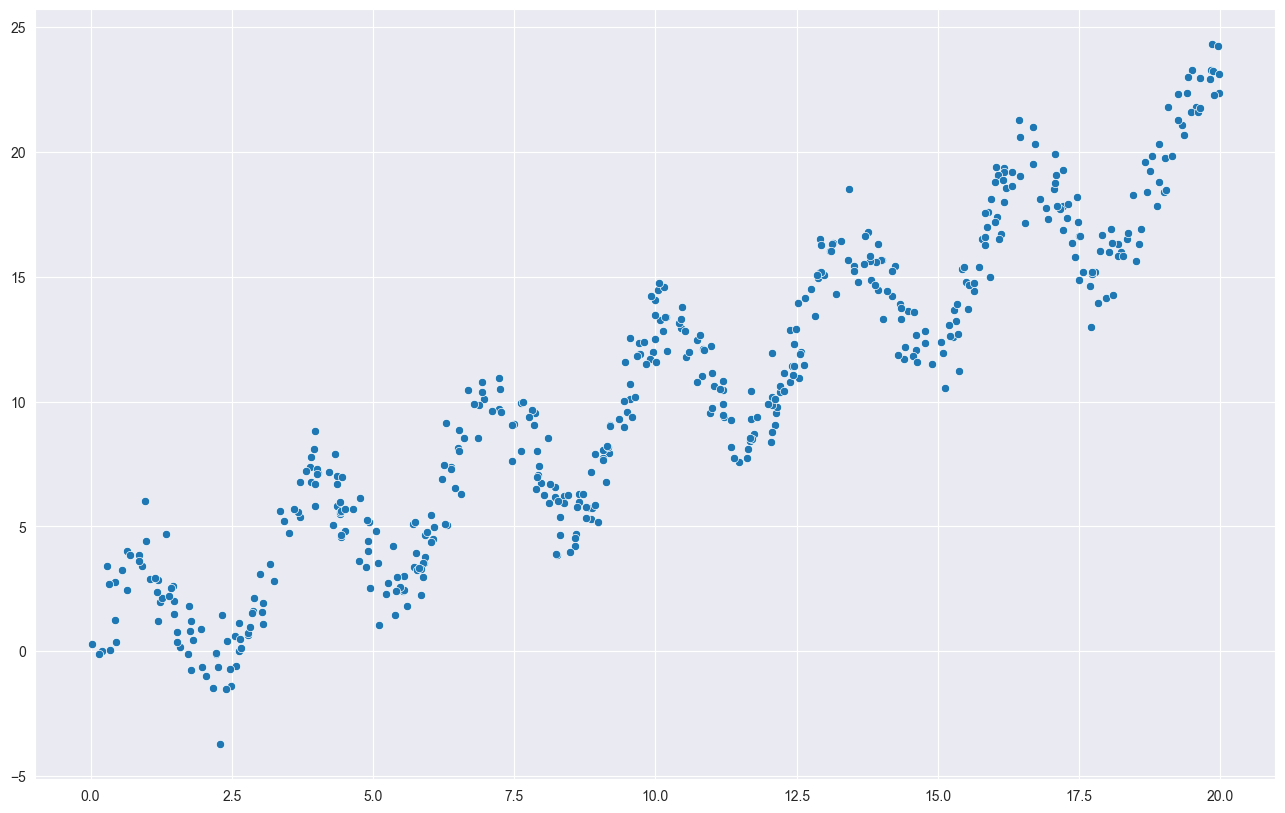

In [8]:
fig = plt.figure()
fig.set_size_inches(16, 10)
sns.scatterplot(x=X.ravel(), y=Y.ravel())
plt.show()

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

splitter = KFold(n_splits=5, shuffle=True, random_state=33)

linear = LinearRegression()
knn = KNeighborsRegressor(n_neighbors=3)

linear_cv = cross_validate(linear, X, Y, cv=splitter, scoring="neg_mean_squared_error", return_train_score=True)

knn_cv = cross_validate(knn, X, Y, cv=splitter, scoring="neg_mean_squared_error", return_train_score=True)

In [13]:
print(f'Среднее MSE линейно модели на трейне: {-np.mean(linear_cv["train_score"]).round(3)}')
print(f'Среднее MSE линейно модели на тесте: {-np.mean(linear_cv["test_score"]).round(3)}')

print(f'Среднее MSE KNN модели на тесте: {-np.mean(knn_cv["train_score"]).round(3)}')
print(f'Среднее MSE KNN модели на тесте: {-np.mean(knn_cv["test_score"]).round(3)}')

Среднее MSE линейно модели на трейне: 5.275
Среднее MSE линейно модели на тесте: 5.314
Среднее MSE KNN модели на тесте: 0.646
Среднее MSE KNN модели на тесте: 1.318


In [14]:
#Покажем недостаток кнн, что он не умеет экстраполировать данные

#Обучим на всей выборке

linear.fit(X,Y)
knn.fit(X,Y)

KNeighborsRegressor(n_neighbors=3)

In [15]:
#Пришли новые данные!

new_X = np.random.uniform(low=20, high=30, size=(50, 1))

new_noise = np.random.normal(loc=0, scale=1, size=(50, 1))

new_Y = target(new_X) + new_noise

knn_preds = knn.predict(new_X)
linear_preds = linear.predict(new_X)

In [17]:
print(f'MSE KNN модели на новых данных: {np.mean((knn_preds - new_Y)**2).round(3)}')
print(f'MSE линейной модели на новых данных: {np.mean((linear_preds - new_Y)**2).round(3)}')

MSE KNN модели на новых данных: 19.74
MSE линейной модели на новых данных: 6.681


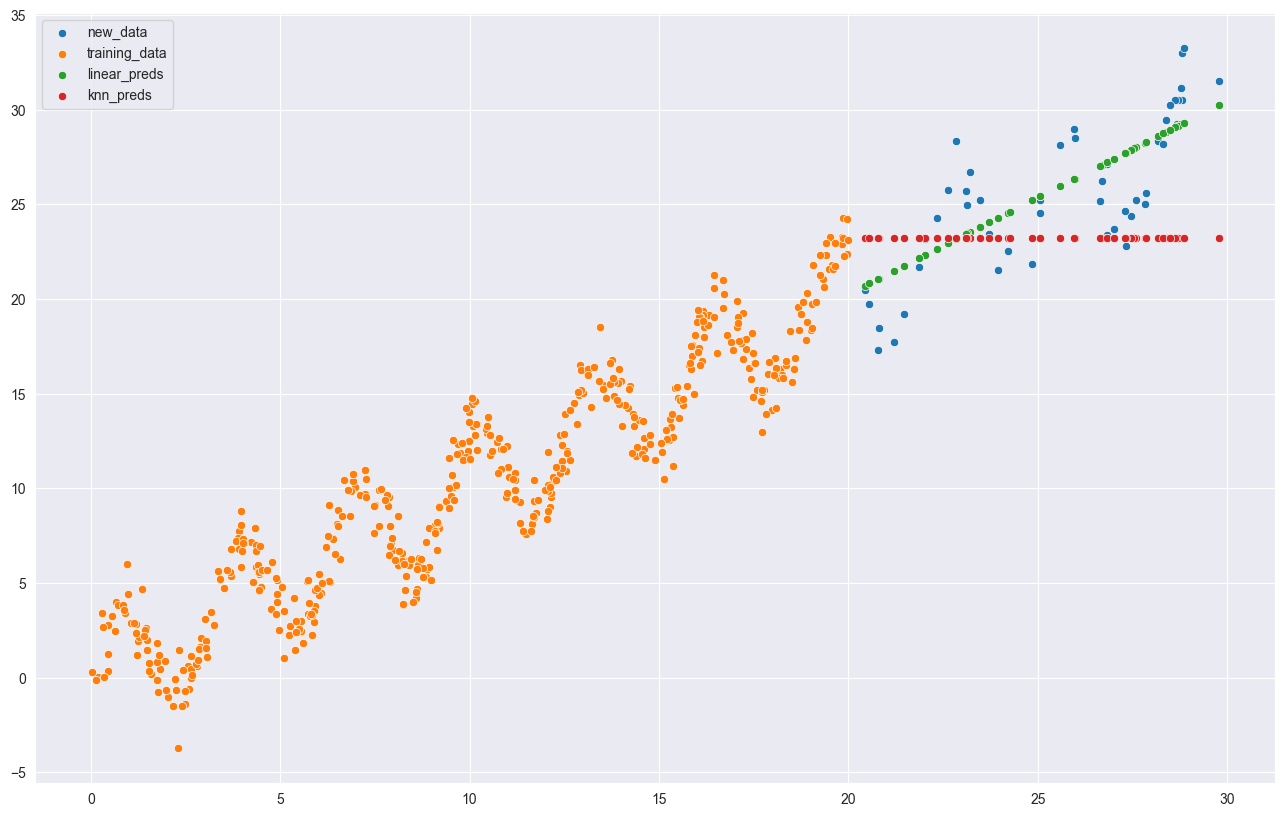

In [18]:
fig = plt.figure()
fig.set_size_inches(16, 10)
sns.scatterplot(x=new_X.ravel(), y=new_Y.ravel())
sns.scatterplot(x=X.ravel(), y=Y.ravel())
sns.scatterplot(x=new_X.ravel(), y=linear_preds.ravel())
sns.scatterplot(x=new_X.ravel(), y=knn_preds.ravel())

plt.legend(["new_data", "training_data", "linear_preds", "knn_preds"])

plt.show()

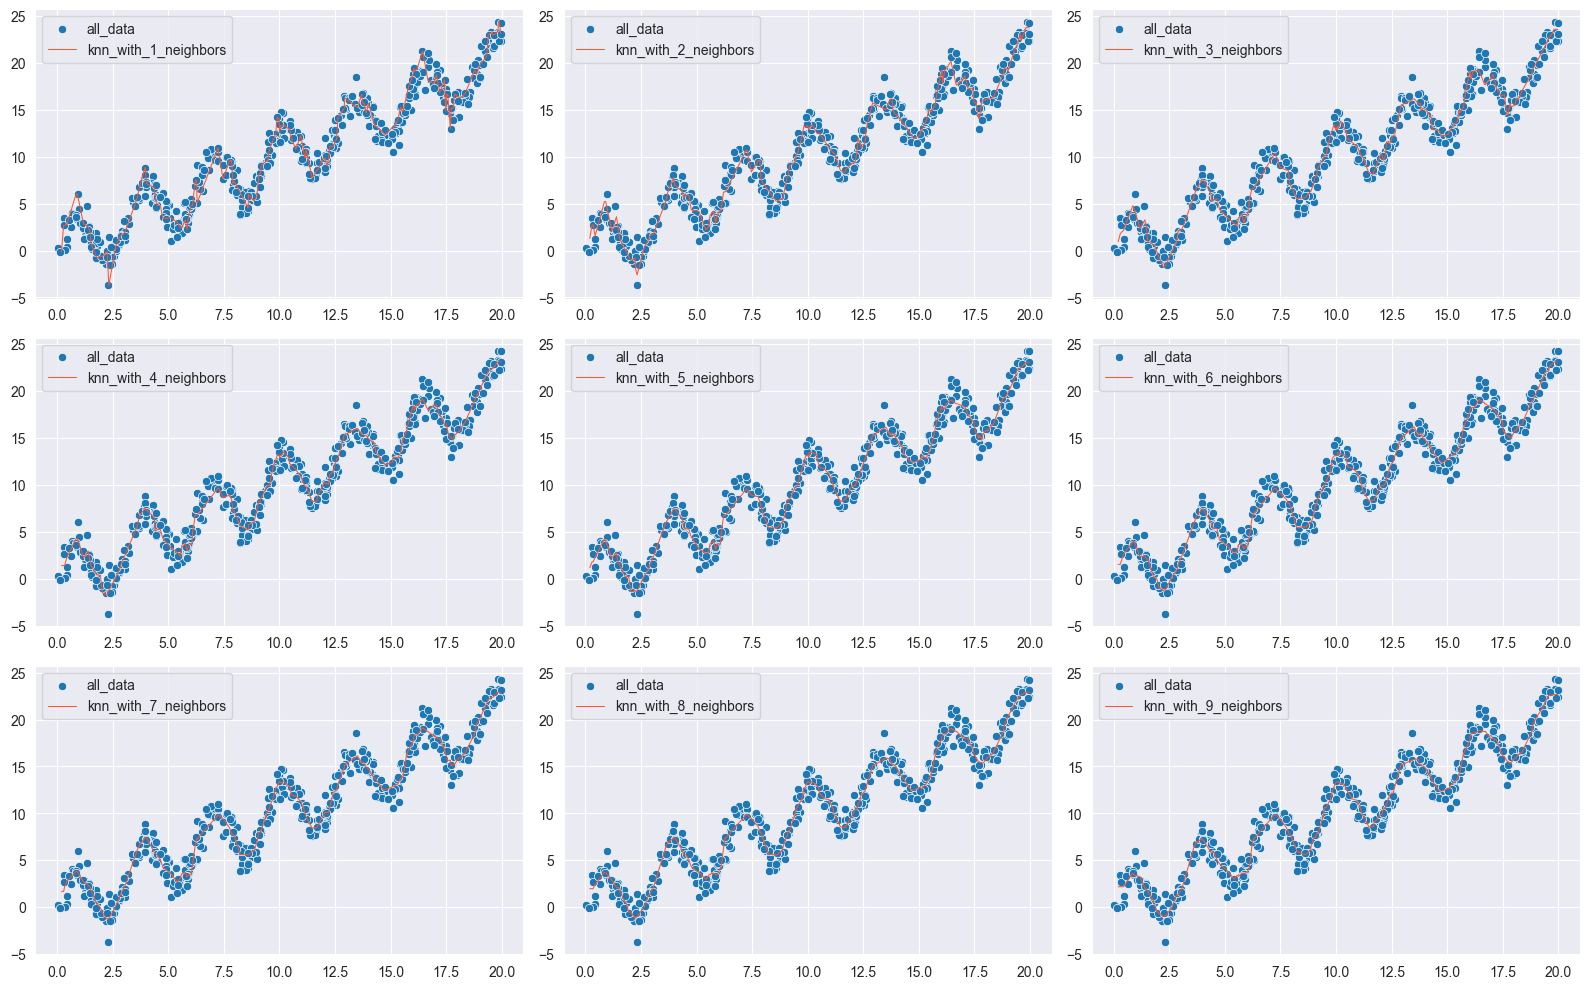

In [21]:
#КНН подбора числа К
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=33)

fig = plt.figure()
fig.set_size_inches(16, 10)

for K in range(1, 10):
    knn = KNeighborsRegressor(n_neighbors=K)
    knn.fit(X_train, y_train)
    preds_test = knn.predict(X_test)
    ax = fig.add_subplot(3, 3, K)
    sns.scatterplot(x=X.ravel(), y=Y.ravel())
    sns.lineplot(x=X_test.ravel(), y=preds_test.ravel(), size=3, color='#FF5533')
    plt.legend(["all_data", f"knn_with_{K}_neighbors"])
fig.tight_layout()

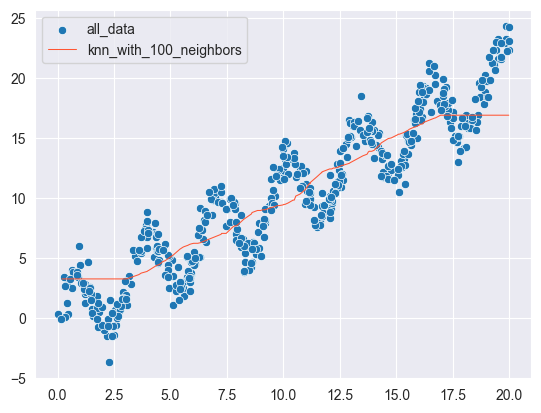

In [26]:
#Очень большие K тоже плохо
knn = KNeighborsRegressor(n_neighbors=100)
knn.fit(X_train, y_train)
preds_test = knn.predict(X_test)
sns.scatterplot(x=X.ravel(), y=Y.ravel())
sns.lineplot(x=X_test.ravel(), y=preds_test.ravel(), size=3, color='#FF5533')
plt.legend(["all_data", f"knn_with_100_neighbors"])

In [27]:
#лучший к можно также найти грид сёрч цв
from sklearn.model_selection import GridSearchCV

param_grid = {"n_neighbors": [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

search = GridSearchCV(knn, param_grid, cv=splitter)

search.fit(X, Y)

print(f"Best parametr (CV score = {search.best_score_:.5f}):")
print(search.best_params_)

Best parametr (CV score = 0.96977):
{'n_neighbors': 9}


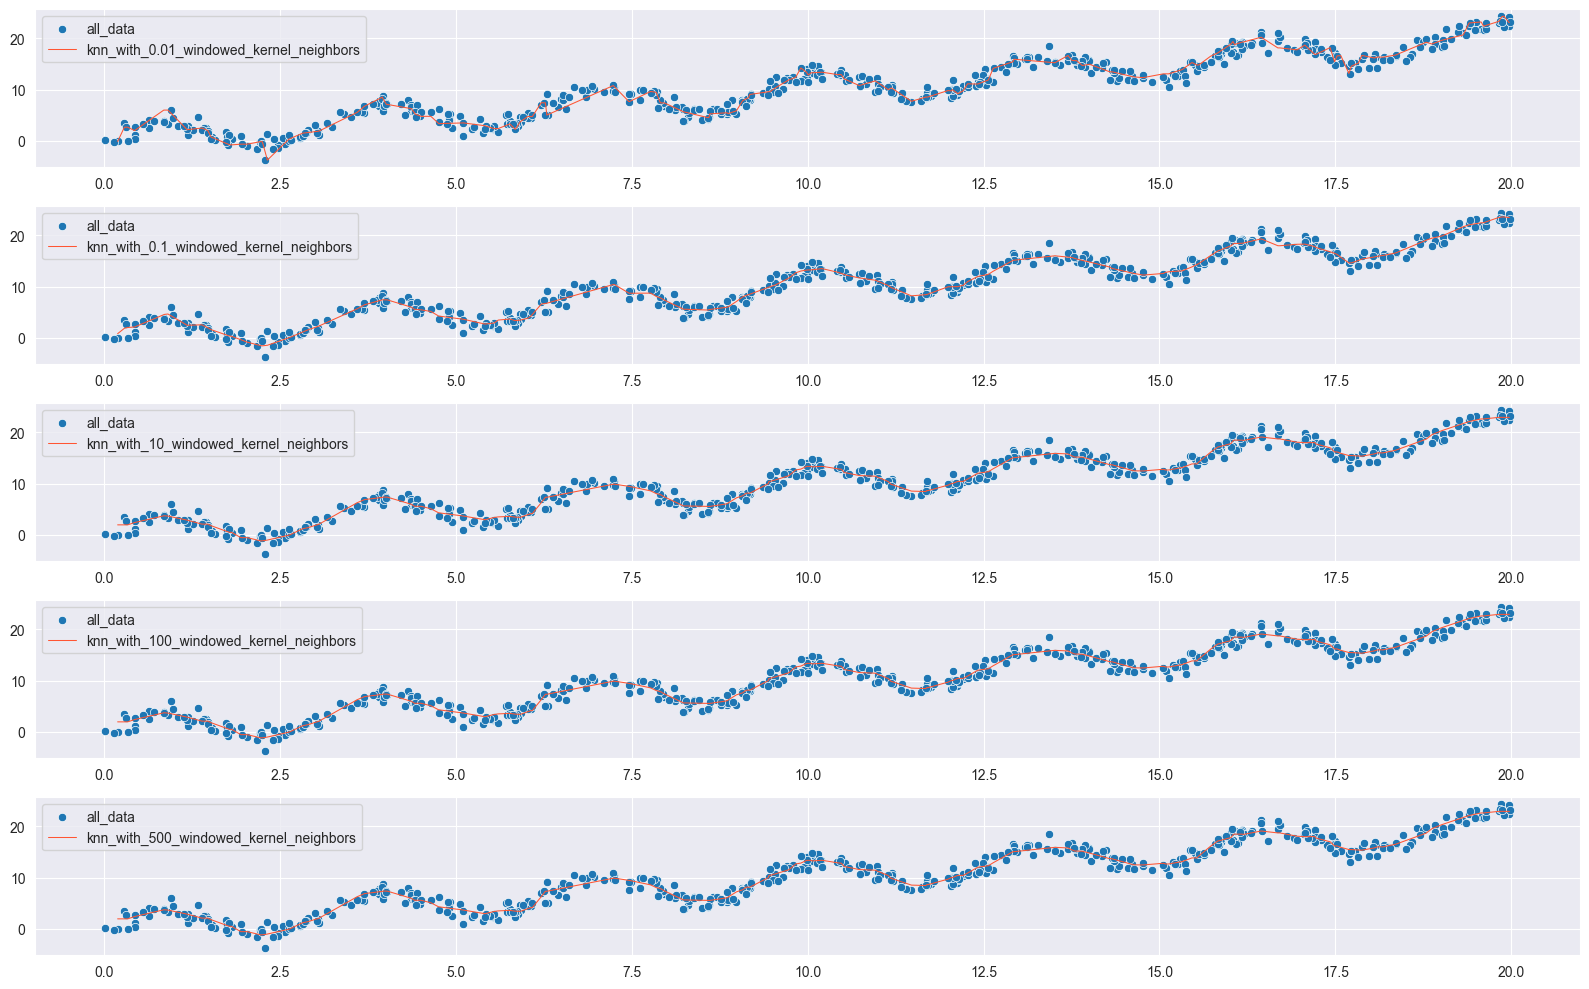

In [28]:
# Ширина Гауссовского ядра
from sklearn.neighbors import KernelDensity
fig = plt.figure()
fig.set_size_inches(16, 10)

k=1

for h in [0.01, 0.1, 10, 100, 500]:
    def kernel(distances, h=h):
        const = 1 / (np.sqrt(2 * np.pi))
        power = (-1/2) * ((distances)**2) / h**2

        return const * np.exp(power)
    knn = KNeighborsRegressor(n_neighbors=8, weights=kernel)
    knn.fit(X_train, y_train)

    preds_test = knn.predict(X_test)

    ax = fig.add_subplot(5, 1, k)

    k += 1

    sns.scatterplot(x=X.ravel(), y=Y.ravel())
    sns.lineplot(x=X_test.ravel(), y=preds_test.ravel(), size=3, color='#FF5533')
    plt.legend(["all_data", f"knn_with_{h}_windowed_kernel_neighbors"])
fig.tight_layout()

In [29]:
#КНН, сегментация клиентов
data = pd.read_excel("processed_segmentation.xlsx")
data.head()

,Age,Work_Experience,Family_Size,Segmentation,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_B,Profession_C,Profession_D,Spending_Score_High,Spending_Score_Low,Var_1_B,Var_1_C,Var_1_D
0,22,1.000000,4.0,D,1,0,0,0.075826,0.109610,0.734985,0,1,0.213039,0.100092,0.381084
1,38,2.641663,3.0,A,0,1,1,0.270386,0.107296,0.251788,0,0,0.213039,0.100092,0.381084
2,67,1.000000,1.0,B,0,1,1,0.270386,0.107296,0.251788,0,1,0.234287,0.285472,0.248400
3,67,0.000000,2.0,B,1,1,1,0.253612,0.224719,0.205457,1,0,0.234287,0.285472,0.248400
4,40,2.641663,6.0,A,0,1,1,0.232877,0.155954,0.226554,1,0,0.234287,0.285472,0.248400


In [30]:
X = data.drop("Segmentation", axis=1)
Y = data["Segmentation"]


In [38]:
def kernel(distances, h=1):
    const = 1 / (np.sqrt(2 * np.pi))
    power = (-1/2) * ((distances)**2) / h**2

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, test_size=0.2)

pipe = Pipeline([("scaler", StandardScaler()), ("KNN", KNeighborsClassifier(weights=kernel))])

pipe.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('KNN',
                 KNeighborsClassifier(weights=<function kernel at 0x0000020079333400>))])

In [41]:
print(f"Качество на трейне: {np.mean(pipe.predict(X_train) == Y_train).round(3)}")
print(f"Качество на тесте: {np.mean(pipe.predict(X_test) == Y_test).round(3)}")

Качество на трейне: 0.636
Качество на тесте: 0.484


In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "KNN__n_neighbors":np.linspace(1, 100, 10, dtype=int),
    "KNN__p": np.linspace(1, 5, 5, dtype=int),
    "KNN__weights": ['uniform', "distance", kernel],
}

from sklearn.model_selection import PredefinedSplit

test_fold = [0 if x in X_train.index else -1 for x in X.index]
ps = PredefinedSplit(test_fold)

search = GridSearchCV(pipe, param_grid, cv=ps)

search.fit(X, Y)

print(f"Best parametr (CV score = {search.best_score_:.5f}):")
print(search.best_params_)

Best parametr (CV score = 0.50031):
{'KNN__n_neighbors': 67, 'KNN__p': 1, 'KNN__weights': 'distance'}


In [42]:
from sklearn.neighbors import KernelDensity